In [15]:
import pandas as pd

df = pd.read_csv("data/interviews.csv")

print(df.shape)
df.head()

(17654, 10)


Company              Title                Job     Level          Date  \
0   Apple  Software Engineer  Software Engineer  Engineer   Aug 7, 2019   
1   Apple  Software Engineer  Software Engineer  Engineer   Aug 8, 2019   
2   Apple  Software Engineer  Software Engineer  Engineer           NaN   
3   Apple  Software Engineer  Software Engineer  Engineer           NaN   
4   Apple  Software Engineer  Software Engineer  Engineer  May 29, 2009   

   Upvotes           Offer  Experience Difficulty  \
0        0        No offer         0.0     Medium   
1        0  Accepted offer         1.0       Hard   
2        0  Declined offer         0.0     Medium   
3        9  Declined offer        -1.0     Medium   
4        2        No offer         0.0     Medium   

                                              Review  
0  Application  I applied through a staffing agen...  
1  Application  I applied online. The process too...  
2  Application  The process took 4 weeks. I inter...  
3  Application  The process took a week. I interv...  
4  Application  I applied through an employee ref...

## 1. pandas is column-major

For our dataset, accessing a row takes about 50x longer than accessing a column in our DataFrame.

In [16]:
# Get the column `date`, 1000 loops
% timeit -n1000 df["Date"]

# Get the first row, 1000 loops
% timeit -n1000 df.iloc[0]

3.27 µs ± 313 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
284 µs ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 1.1 Iterating over rows
1.1.1 .apply()

For example, to scale the "Experience" column by the number of "Upvotes" each review has, one way is to iteratate over rows and multiple the "Upvotes" value by the "Experience" value of that row.
But you can also use .apply() with a lambda function.

In [17]:
% timeit -n1 df.apply( lambda x: x["Upvotes"] * x["Experience"], axis=1)


687 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1.1.2 .iterrows() and .itertuples()
If you really want to iterate over rows, one naive way is to use .iterrows(). It returns a generator that generates row by row and it's very slow.


In [18]:
% timeit -n1[row for index, row in df.iterrows()]

2.27 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
# this is what pandas looks like as a panda object
for index, row in df.iterrows():
    print(row)
    break

Company                                                   Apple
Title                                         Software Engineer
Job                                           Software Engineer
Level                                                  Engineer
Date                                                Aug 7, 2019
Upvotes                                                       0
Offer                                                  No offer
Experience                                                    0
Difficulty                                               Medium
Review        Application  I applied through a staffing agen...
Name: 0, dtype: object


.itertuples() returns rows in the namedtuple format. It still lets you access each row and it's about 40x faster than .iterrows().



In [20]:
% timeit -n1[row for row in df.itertuples()]

# this is what it looks like as tuple object
for row in df.itertuples():
    print(row)
    break

39.3 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Pandas(Index=0, Company='Apple', Title='Software Engineer', Job='Software Engineer', Level='Engineer', Date='Aug 7, 2019', Upvotes=0, Offer='No offer', Experience=0.0, Difficulty='Medium', Review='Application  I applied through a staffing agency. I interviewed at Apple (Sunnyvale, CA) in March 2019.  Interview  The interviewer asked me about my background. Asked few questions from the resume. Asked about my proficiency on data structures. Asked me how do you sort hashmap keys based on values.  Interview Questions Write a program that uses two threads to print the numbers from 1 to n.')


### 1.1.3 Converting DataFrame to row-major order
If you need to do a lot of row operations, you might want to convert your DataFrame to a NumPy's row-major ndarray, then iterating through the rows.

In [22]:
# Now, iterating through our DataFrame is 100x faster.
% timeit -n1 df_np = df.to_numpy(); rows =[row for row in df_np]

7.27 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Accessing a row or a column of our ndarray takes nanoseconds instead of microseconds.


In [24]:
df_np = df.to_numpy()
% timeit -n1000 df_np[0]
% timeit -n1000 df_np[:, 0]

229 ns ± 19.7 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
344 ns ± 86 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 1.2. Ordering slicing operations

Because pandas is column-major, if you want to do multiple slicing operations, always do the column-based slicing operations first.

For example, if you want to get the review from the first row of the data, there are two slicing operations:

get row (row-based operation)
get review (column-based operation)
Get row -> get review is 25x slower than get review -> get row.

Note: You can also just use df.loc[0, "Review"] to calculate the memory address to retrieve the item. Its performance is comparable to get review then get row.

In [27]:
% timeit -n1000 df["Review"][0]
% timeit -n1000 df.iloc[0]["Review"]
% timeit -n1000 df.loc[0, "Review"]

34.9 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
337 µs ± 130 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.8 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


2. SettingWithCopyWarning
Sometimes, when you try to assign values to a subset of data in a DataFrame,
you get SettingWithCopyWarning. Don't ignore the warning because it means sometimes, the assignment works (example 1), but sometimes, it doesn't (example 2).


In [30]:
# Example 1: Changing the review of the first row.
df["Review"][0] = "I like Orange better."
# Even though with the warning, the assignment works. The review is updated.
df.head(1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Company              Title                Job     Level         Date  \
0   Apple  Software Engineer  Software Engineer  Engineer  Aug 7, 2019   

   Upvotes     Offer  Experience Difficulty                 Review  
0        0  No offer         0.0     Medium  I like Orange better.

In [34]:
# Example 2: Changing the company name Apple to Orange.
df[df["Company"] == "Apple"]["Company"] = "Orange"
# With the warning, the assignment doesn't work. The company name is still Apple.
df.head(1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Company              Title                Job     Level         Date  \
0   Apple  Software Engineer  Software Engineer  Engineer  Aug 7, 2019   

   Upvotes     Offer  Experience Difficulty                 Review  
0        0  No offer         0.0     Medium  I like Orange better.

### 2.1. View vs. Copy
To understand this weird behavior, we need to understand two concepts in pandas: View vs. Copy.

View is the actual DataFrame you want to work with.
Copy is a copy of that actual DataFrame, which will be thrown away as soon as the operation is done.
So if you try to do an assignment on a Copy, the assignment won't work.

SettingWithCopyWarning doesn't mean you're making changes to a Copy. It means that the thing you're making changes to might be a Copy or a View, and pandas can't tell you.

The ambiguity happens because of __getitem__ operation. __getitem__ sometimes returns a Copy, sometimes a View, and pandas makes no guarantee.

### 2.2 Solutions
2.2.1 Combine all chained operations into one single operation
To avoid __getitem__ ambiguity, you can combine all your operations into one single operation. .loc[] is usually great for that.



In [36]:
df.loc[0, "Review"] = "Orange is love. Orange is life."
df.head(1)

Company              Title                Job     Level         Date  \
0   Apple  Software Engineer  Software Engineer  Engineer  Aug 7, 2019   

   Upvotes     Offer  Experience Difficulty                           Review  
0        0  No offer         0.0     Medium  Orange is love. Orange is life.

In [39]:

# Changing the company name Apple to Orange.
df.loc[df["Company"] == "Apple", "Company"] = "Orange"
df.head()

Company              Title                Job     Level          Date  \
0  Orange  Software Engineer  Software Engineer  Engineer   Aug 7, 2019   
1  Orange  Software Engineer  Software Engineer  Engineer   Aug 8, 2019   
2  Orange  Software Engineer  Software Engineer  Engineer           NaN   
3  Orange  Software Engineer  Software Engineer  Engineer           NaN   
4  Orange  Software Engineer  Software Engineer  Engineer  May 29, 2009   

   Upvotes           Offer  Experience Difficulty  \
0        0        No offer         0.0     Medium   
1        0  Accepted offer         1.0       Hard   
2        0  Declined offer         0.0     Medium   
3        9  Declined offer        -1.0     Medium   
4        2        No offer         0.0     Medium   

                                              Review  
0                    Orange is love. Orange is life.  
1  Application  I applied online. The process too...  
2  Application  The process took 4 weeks. I inter...  
3  Application  The process took a week. I interv...  
4  Application  I applied through an employee ref...

## 3. Indexing and slicing
### 3.1 .iloc[]: selecting rows based on integer indices¶


In [41]:
# Accessing the third row of a `DataFrame`.
df.iloc[3]

Company                                                  Orange
Title                                         Software Engineer
Job                                           Software Engineer
Level                                                  Engineer
Date                                                        NaN
Upvotes                                                       9
Offer                                            Declined offer
Experience                                                   -1
Difficulty                                               Medium
Review        Application  The process took a week. I interv...
Name: 3, dtype: object

In [43]:
# Selecting the last 6 rows
df.iloc[-6:]

Company              Title                Job     Level          Date  \
17648  Tencent  Software Engineer  Software Engineer  Engineer   Nov 4, 2012   
17649  Tencent  Software Engineer  Software Engineer  Engineer  May 25, 2012   
17650  Tencent  Software Engineer  Software Engineer  Engineer  Mar 15, 2014   
17651  Tencent  Software Engineer  Software Engineer  Engineer  Sep 22, 2015   
17652  Tencent  Software Engineer  Software Engineer  Engineer   Jul 4, 2017   
17653  Tencent  Software Engineer  Software Engineer  Engineer  Sep 30, 2016   

       Upvotes           Offer  Experience Difficulty  \
17648        0        No offer         NaN        NaN   
17649        0  Declined offer         0.0     Medium   
17650        0        No offer         NaN        NaN   
17651        0  Accepted offer         1.0     Medium   
17652        0  Declined offer         1.0     Medium   
17653        0  Declined offer         0.0       Easy   

                                                  Review  
17648  Application  I applied online. The process too...  
17649  Application  I applied online. The process too...  
17650  Application  I applied through college or univ...  
17651  Application  I applied through college or univ...  
17652  Application  I applied through college or univ...  
17653  Application  I applied online. The process too...

In [45]:
# Selecting 1 from every 2 rows in the last 6 rows
df.iloc[-6::2]

Company              Title                Job     Level          Date  \
17648  Tencent  Software Engineer  Software Engineer  Engineer   Nov 4, 2012   
17650  Tencent  Software Engineer  Software Engineer  Engineer  Mar 15, 2014   
17652  Tencent  Software Engineer  Software Engineer  Engineer   Jul 4, 2017   

       Upvotes           Offer  Experience Difficulty  \
17648        0        No offer         NaN        NaN   
17650        0        No offer         NaN        NaN   
17652        0  Declined offer         1.0     Medium   

                                                  Review  
17648  Application  I applied online. The process too...  
17650  Application  I applied through college or univ...  
17652  Application  I applied through college or univ...


### 3.2 .loc[]: selecting rows by labels or boolean masks
.loc[] lets you select rows based on one of the two things:

boolean masks
labels

#### 3.2.1 Selecting rows by boolean masks
If you want to select all the rows where candidates declined offer, you can do it with two steps:

Create a boolean mask on whether the "Offer" column equals to "Declined offer"
Use that mask to select rows


In [49]:
df[df["Offer"] == "Declined offer"]
# This is equivalent to:
# mask = df["Offer"] == "Declined offer"
# df.loc[mask]

Company                     Title                Job     Level  \
2          Orange         Software Engineer  Software Engineer  Engineer   
3          Orange         Software Engineer  Software Engineer  Engineer   
7          Orange         Software Engineer  Software Engineer  Engineer   
17         Orange         Software Engineer  Software Engineer  Engineer   
65         Orange         Software Engineer  Software Engineer  Engineer   
91         Orange         Software Engineer  Software Engineer  Engineer   
109        Orange         Software Engineer  Software Engineer  Engineer   
123        Orange         Software Engineer  Software Engineer  Engineer   
124        Orange         Software Engineer  Software Engineer  Engineer   
144        Orange         Software Engineer  Software Engineer  Engineer   
160        Orange         Software Engineer  Software Engineer  Engineer   
162        Orange         Software Engineer  Software Engineer  Engineer   
164        Orange         Software Engineer  Software Engineer  Engineer   
172        Orange         Software Engineer  Software Engineer  Engineer   
173        Orange         Software Engineer  Software Engineer  Engineer   
177        Orange         Software Engineer  Software Engineer  Engineer   
181        Orange         Software Engineer  Software Engineer  Engineer   
185        Orange         Software Engineer  Software Engineer  Engineer   
195        Orange         Software Engineer  Software Engineer  Engineer   
228        Orange         Software Engineer  Software Engineer  Engineer   
234        Orange         Software Engineer  Software Engineer  Engineer   
240        Orange         Software Engineer  Software Engineer  Engineer   
248        Orange         Software Engineer  Software Engineer  Engineer   
269        Orange         Software Engineer  Software Engineer  Engineer   
313        Orange  Senior Software Engineer  Software Engineer    Senior   
316        Orange  Senior Software Engineer  Software Engineer    Senior   
322        Orange  Senior Software Engineer  Software Engineer    Senior   
331        Orange  Senior Software Engineer  Software Engineer    Senior   
333        Orange  Senior Software Engineer  Software Engineer    Senior   
337        Orange  Senior Software Engineer  Software Engineer    Senior   
...           ...                       ...                ...       ...   
17206      PayPal  Senior Software Engineer  Software Engineer    Senior   
17219        Snap         Software Engineer  Software Engineer  Engineer   
17220        Snap         Software Engineer  Software Engineer  Engineer   
17227        Snap         Software Engineer  Software Engineer  Engineer   
17269        Snap         Software Engineer  Software Engineer  Engineer   
17281        Snap         Software Engineer  Software Engineer  Engineer   
17294        Snap         Software Engineer  Software Engineer  Engineer   
17309        Snap         Software Engineer  Software Engineer  Engineer   
17360  Salesforce         Software Engineer  Software Engineer  Engineer   
17361  Salesforce         Software Engineer  Software Engineer  Engineer   
17363  Salesforce         Software Engineer  Software Engineer  Engineer   
17393  Salesforce         Software Engineer  Software Engineer  Engineer   
17401  Salesforce         Software Engineer  Software Engineer  Engineer   
17447  Salesforce         Software Engineer  Software Engineer  Engineer   
17451  Salesforce         Software Engineer  Software Engineer  Engineer   
17481  Salesforce         Software Engineer  Software Engineer  Engineer   
17496  Salesforce         Software Engineer  Software Engineer  Engineer   
17498  Salesforce         Software Engineer  Software Engineer  Engineer   
17499  Salesforce         Software Engineer  Software Engineer  Engineer   
17510  Salesforce         Software Engineer  Software Engineer  Engineer   
17519  Salesforce         Software Engineer  Software Engi

### 3.2.2 Selecting rows by labels
#### 3.2.2.1 Creating labels
Currently, our DataFrame has no labels yet.
To create labels, use .set_index().

Labels can be integers or strings
A DatamFrame can have multiple labels


In [64]:
# Adding label "Hardware" if the company name is "Orange", "Dell", "IDM", or "Siemens".
# "Orange" because we changed "Apple" to "Orange" above.
# Adding label "Software" otherwise.

def company_type(x):
    hardware_companies = set(["Orange", "Dell", "IDM", "Siemens"])
    return "Hardware" if x["Company"] in hardware_companies else "Software"

df["Type"] = df.apply(lambda x: company_type(x), axis=1)

# Setting "Type" to be labels. We call ""
df = df.set_index("Type")
df
# Label columns aren't considered part of the DataFrame's content.
# After adding labels to your DataFrame, it still has 10 columns, same as before.

Company                     Title                Job     Level  \
Type                                                                          
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
Hardware      Orange         Software Engineer  Software Engineer  Engineer   
...              ...                       ...                ...       ...   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software  Salesforce  Senior Software Engineer  Software Engineer    Senior   
Software     Tencent         Software Engineer  Software Engineer  Engineer   
Software     Tencent         Software Engineer  Software Engine

#### 3.2.2.1 Selecting rows by labels

In [67]:
# Selecting rows with label "Hardware"
df.loc["Hardware"]

Company                     Title                Job     Level  \
Type                                                                      
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
Hardware  Orange         Software Engineer  Software Engineer  Engineer   
...          ...                       ...                ...       ...   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software Engineer  Software Engineer    Senior   
Hardware    Dell  Senior Software 

In [71]:
# To drop a label, you need to use reset_index with drop=True
df.reset_index(drop=True, inplace=True)
df

Company                     Title                Job     Level  \
0          Orange         Software Engineer  Software Engineer  Engineer   
1          Orange         Software Engineer  Software Engineer  Engineer   
2          Orange         Software Engineer  Software Engineer  Engineer   
3          Orange         Software Engineer  Software Engineer  Engineer   
4          Orange         Software Engineer  Software Engineer  Engineer   
5          Orange         Software Engineer  Software Engineer  Engineer   
6          Orange         Software Engineer  Software Engineer  Engineer   
7          Orange         Software Engineer  Software Engineer  Engineer   
8          Orange         Software Engineer  Software Engineer  Engineer   
9          Orange         Software Engineer  Software Engineer  Engineer   
10         Orange         Software Engineer  Software Engineer  Engineer   
11         Orange         Software Engineer  Software Engineer  Engineer   
12         Orange         Software Engineer  Software Engineer  Engineer   
13         Orange         Software Engineer  Software Engineer  Engineer   
14         Orange         Software Engineer  Software Engineer  Engineer   
15         Orange         Software Engineer  Software Engineer  Engineer   
16         Orange         Software Engineer  Software Engineer  Engineer   
17         Orange         Software Engineer  Software Engineer  Engineer   
18         Orange         Software Engineer  Software Engineer  Engineer   
19         Orange         Software Engineer  Software Engineer  Engineer   
20         Orange         Software Engineer  Software Engineer  Engineer   
21         Orange         Software Engineer  Software Engineer  Engineer   
22         Orange         Software Engineer  Software Engineer  Engineer   
23         Orange         Software Engineer  Software Engineer  Engineer   
24         Orange         Software Engineer  Software Engineer  Engineer   
25         Orange         Software Engineer  Software Engineer  Engineer   
26         Orange         Software Engineer  Software Engineer  Engineer   
27         Orange         Software Engineer  Software Engineer  Engineer   
28         Orange         Software Engineer  Software Engineer  Engineer   
29         Orange         Software Engineer  Software Engineer  Engineer   
...           ...                       ...                ...       ...   
17624  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17625  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17626  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17627  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17628  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17629  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17630  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17631  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17632  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17633  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17634  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17635  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17636  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17637  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17638  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17639  Salesforce  Senior Software Engineer  Software Engineer    Senior   
17640     Tencent         Software Engineer  Software Engineer  Engineer   
17641     Tencent         Software Engineer  Software Engineer  Engineer   
17642     Tencent         Software Engineer  Software Engineer  Engineer   
17643     Tencent         Software Engineer  Software Engineer  Engineer   
17644     Tencent         Software Engineer  Software Engi

## 3.3 Slicing Series
Slicing pandas Series is similar to slicing in Python.



In [80]:
series = df.Company
# The first 1000 companies, picking every 100th companies
series[:1000:100]

0      Orange
100    Orange
200    Orange
300    Orange
400     Intel
500     Intel
600     Intel
700     Intel
800      Uber
900      Uber
Name: Company, dtype: object

## 4. Accessors

### 4.1 string accessor



In [82]:
# If you want to lowercase all the reviews in the `Reviews` column.
df["Review"].str.lower()

0                          orange is love. orange is life.
1        application  i applied online. the process too...
2        application  the process took 4 weeks. i inter...
3        application  the process took a week. i interv...
4        application  i applied through an employee ref...
5        application  i applied through college or univ...
6        application  the process took 2 days. i interv...
7        application  the process took 4+ weeks. i inte...
8        application  i applied online. i interviewed a...
9        application  i applied online. the process too...
10       application  i applied through college or univ...
11       interview  phone interview then onsite intervi...
12       interview  i got two phone interviews, one is ...
13       application  the process took 2 weeks. i inter...
14       application  i applied through college or univ...
15       application  i applied online. the process too...
16       application  i applied online. the process too.

In [84]:
## Or if you want to get the length of all the reviews
df["Review"].str.len()

0          31
1         670
2         350
3         807
4         663
5         321
6        1576
7         294
8         377
9        1359
10        426
11        256
12        285
13        551
14        838
15        906
16       1123
17       1742
18        527
19        587
20       1278
21       1064
22       1167
23        404
24       1382
25        840
26        208
27        342
28        402
29        341
         ... 
17624    1144
17625     403
17626     381
17627     621
17628     803
17629     653
17630     768
17631     749
17632     727
17633    1142
17634     446
17635     436
17636    1088
17637    1352
17638    1262
17639     605
17640     380
17641     441
17642     382
17643     466
17644     243
17645     469
17646     870
17647     462
17648     341
17649     470
17650     394
17651     524
17652     391
17653     784
Name: Review, Length: 17654, dtype: int64

.str can be very powerful if you use it with Regex. Imagine you want to get a sense of how long the interview process takes for each review. You notice that each review mentions how long it takes such as "the process took 4 weeks". So you use this heuristic:

- a process is short if it takes days
- a process is average is if it takes weeks
- a process is long if it takes at least 4 weeks

In [91]:
df.loc[df["Review"].str.contains("days"), "Process"] = "Short"
df.loc[df["Review"].str.contains("week"), "Process"] = "Average"
df.loc[df["Review"].str.contains("month|[4-9]+[^ ]* weeks|[1-9]\d{1,}[^ ]* weeks"), "Process"] = "Long"

df.loc[~df.Process.isna(), ["Review", "Process"]]

Review  Process
1      Application  I applied online. The process too...     Long
2      Application  The process took 4 weeks. I inter...     Long
3      Application  The process took a week. I interv...  Average
5      Application  I applied through college or univ...     Long
6      Application  The process took 2 days. I interv...    Short
7      Application  The process took 4+ weeks. I inte...     Long
9      Application  I applied online. The process too...  Average
10     Application  I applied through college or univ...     Long
13     Application  The process took 2 weeks. I inter...  Average
15     Application  I applied online. The process too...    Short
16     Application  I applied online. The process too...     Long
17     Application  The process took 1 day. I intervi...  Average
19     Application  I applied through an employee ref...    Short
20     Application  I applied in-person. The process ...  Average
21     Application  I applied online. The process too...  Average
22     Application  I applied through an employee ref...    Short
23     Application  I applied through a recruiter. Th...  Average
24     Application  The process took 4 weeks. I inter...     Long
29     Application  I applied online. I interviewed a...  Average
30     Application  I applied through an employee ref...     Long
31     Application  I applied online. The process too...  Average
32     Interview  Its was a 3 week process  Interview...  Average
33     Application  I applied through a recruiter. Th...  Average
37     Application  I applied through an employee ref...     Long
38     Application  I applied through other source. T...  Average
39     Application  I applied through a recruiter. Th...     Long
41     Application  I applied online. The process too...     Long
43     Application  I applied online. The process too...  Average
47     Application  The process took 3 weeks. I inter...  Average
50     Application  I applied through a recruiter. Th...     Long
...                                                  ...      ...
17612  Application  I applied through a recruiter. Th...  Average
17613  Application  I applied through a recruiter. Th...  Average
17615  Application  I applied through a recruiter. Th...     Long
17617  Application  I applied through an employee ref...     Long
17618  Application  I applied online. The process too...     Long
17619  Application  I applied online. The process too...  Average
17620  Application  I applied through a recruiter. Th...    Short
17621  Application  I applied through an employee ref...    Short
17622  Application  I applied through college or univ...  Average
17624  Application  I applied online. The process too...  Average
17625  Application  I applied through an employee ref...  Average
17626  Application  I applied through an employee ref...  Average
17628  Application  I applied through a staffing agen...    Short
17629  Application  I applied through an employee ref...  Average
17630  Application  I applied online. The process too...     Long
17631  Application  I applied through an employee ref...     Long
17632  Application  I applied through a recruiter. Th...     Long
17633  Application  I applied online. The process too...     Long
17634  Application  I applied through an employee ref...  Average
17636  Application  I applied through an employee ref...    Short
17637  Application  I applied through a recruiter. Th...  Average
17638  Application  I applied through a recruiter. Th...    Short
17639  Application  I applied online. The process too...     Long
17640  Interview  2 weeks, 5 round tech interviews, i...  Average
17642  Application  I applied online. The process too...  Average
17645  Application  I applied online. The process too...  Average
17647  Application  I applied through college or univ...     Long
17648  Application  I applied online. The process too...    Short
17649  Application  I applied online. The process too...  Average
17653  Application  I ap

We want to sanity check if Process corresponds to Review, but Review is cut off in the display above. To show longer columns, you can set display.max_colwidth to 100.

Note: set_option has several great options you should check out.

In [94]:
pd.set_option('display.max_colwidth', 100)
df[~df.Process.isna()][["Review", "Process"]]

Review  \
1      Application  I applied online. The process took 2+ months. I interviewed at Apple (San Jose, CA)...   
2      Application  The process took 4 weeks. I interviewed at Apple (San Antonio, TX) in February 2016...   
3      Application  The process took a week. I interviewed at Apple (Cupertino, CA) in December 2008.  ...   
5      Application  I applied through college or university. The process took 6 weeks. I interviewed at...   
6      Application  The process took 2 days. I interviewed at Apple (Cupertino, CA) in March 2009.  Int...   
7      Application  The process took 4+ weeks. I interviewed at Apple in May 2019.  Interview  Not a gr...   
9      Application  I applied online. The process took 2 weeks. I interviewed at Apple (Cupertino, CA) ...   
10     Application  I applied through college or university. The process took 5 weeks. I interviewed at...   
13     Application  The process took 2 weeks. I interviewed at Apple in September 2009.  Interview  I w...   
15     Application  I applied online. The process took 4 days. I interviewed at Apple (Cupertino, CA) i...   
16     Application  I applied online. The process took 5 weeks. I interviewed at Apple (Cupertino, CA) ...   
17     Application  The process took 1 day. I interviewed at Apple (Cupertino, CA) in June 2008.  Inter...   
19     Application  I applied through an employee referral. The process took 2 days. I interviewed at A...   
20     Application  I applied in-person. The process took 3 weeks. I interviewed at Apple (Cupertino, C...   
21     Application  I applied online. The process took 3 weeks. I interviewed at Apple (Cupertino, CA) ...   
22     Application  I applied through an employee referral. The process took 5 days. I interviewed at A...   
23     Application  I applied through a recruiter. The process took 2 weeks. I interviewed at Apple (Cu...   
24     Application  The process took 4 weeks. I interviewed at Apple (Cupertino, CA) in February 2011. ...   
29     Application  I applied online. I interviewed at Apple.  Interview  phone interview -&gt;onsite i...   
30     Application  I applied through an employee referral. The process took 4+ weeks. I interviewed at...   
31     Application  I applied online. The process took a week. I interviewed at Apple (Cupertino, CA). ...   
32                   Interview  Its was a 3 week process  Interview Questions Do you own a apple product?"   
33     Application  I applied through a recruiter. The process took 2 weeks. I interviewed at Apple (Cu...   
37     Application  I applied through an employee referral. The process took 4+ weeks. I interviewed at...   
38     Application  I applied through other source. The process took 2+ weeks. I interviewed at Apple. ...   
39     Application  I applied through a recruiter. The process took 2 weeks. I interviewed at Apple (Cu...   
41     Application  I applied online. The process took 4+ weeks. I interviewed at Apple.  Interview  1 ...   
43     Application  I applied online. The process took a week. I interviewed at Apple (Cupertino, CA) i...   
47     Application  The process took 3 weeks. I interviewed at Apple (Cupertino, CA) in June 2008.  Int...   
50     Application  I applied through a recruiter. The process took 4+ weeks. I interviewed at Apple (C...   
...                                                                                                    ...   
17612  Application  I applied through a recruiter. The process took 3 weeks. I interviewed at Salesforc...   
17613  Application  I applied through a recruiter. The process took a week. I interviewed at Salesforce...   
17615  Application  I applied through a recruiter. The process took 4 weeks. I interviewed at Salesforc...   
17617  Application  I applied through an employee referral. The process took 4+ weeks. I interviewed at...   
17618  Application  I applied online. The process took 5 weeks. I interviewed at Salesforce (San Franci...   
17619  Application  I applied 

In [96]:
# To see the built-in functions available for `.str`, use this
pd.Series.str.__dict__.keys()

dict_keys(['__module__', '__doc__', '__init__', '_validate', '__getitem__', '__iter__', '_wrap_result', '_get_series_list', 'cat', 'split', 'rsplit', 'partition', 'rpartition', 'get', 'join', 'contains', 'match', 'replace', 'repeat', 'pad', 'center', 'ljust', 'rjust', 'zfill', 'slice', 'slice_replace', 'decode', 'encode', 'strip', 'lstrip', 'rstrip', 'wrap', 'get_dummies', 'translate', 'count', 'startswith', 'endswith', 'findall', 'extract', 'extractall', 'find', 'rfind', 'normalize', 'index', 'rindex', 'len', 'lower', 'upper', 'title', 'capitalize', 'swapcase', 'isalnum', 'isalpha', 'isdigit', 'isspace', 'islower', 'isupper', 'istitle', 'isnumeric', 'isdecimal', '_make_accessor'])


## 4.2 Other accessors
pandas Series has 3 other accessors.

- .dt: handles date formats
- .cat: handles categorical data
- .sparse: handles sparse matrices

In [98]:
pd.Series._accessors

{'cat', 'dt', 'sparse', 'str'}

## 5. Data exploration

### 5.1 .head(), .tail(), .describe(), .info()



In [100]:
# Get the last 8 entries
df.tail(8)

Company              Title                Job     Level          Date  \
17646  Tencent  Software Engineer  Software Engineer  Engineer  May 28, 2010   
17647  Tencent  Software Engineer  Software Engineer  Engineer  Apr 11, 2019   
17648  Tencent  Software Engineer  Software Engineer  Engineer   Nov 4, 2012   
17649  Tencent  Software Engineer  Software Engineer  Engineer  May 25, 2012   
17650  Tencent  Software Engineer  Software Engineer  Engineer  Mar 15, 2014   
17651  Tencent  Software Engineer  Software Engineer  Engineer  Sep 22, 2015   
17652  Tencent  Software Engineer  Software Engineer  Engineer   Jul 4, 2017   
17653  Tencent  Software Engineer  Software Engineer  Engineer  Sep 30, 2016   

       Upvotes           Offer  Experience Difficulty  \
17646        0  Declined offer         0.0       Easy   
17647        0  Accepted offer         1.0     Medium   
17648        0        No offer         NaN        NaN   
17649        0  Declined offer         0.0     Medium   
17650        0        No offer         NaN        NaN   
17651        0  Accepted offer         1.0     Medium   
17652        0  Declined offer         1.0     Medium   
17653        0  Declined offer         0.0       Easy   

                                                                                                    Review  \
17646  Application  I applied through an employee referral. The process took 1 day. I interviewed at Te...   
17647  Application  I applied through college or university. The process took 4+ weeks. I interviewed a...   
17648  Application  I applied online. The process took 2 days. I interviewed at Tencent.  Interview  I ...   
17649  Application  I applied online. The process took a week. I interviewed at Tencent (Beijing, Beiji...   
17650  Application  I applied through college or university. I interviewed at Tencent.  Interview  Prof...   
17651  Application  I applied through college or university. The process took 1 day. I interviewed at T...   
17652  Application  I applied through college or university. I interviewed at Tencent (London, England ...   
17653  Application  I applied online. The process took 3+ weeks. I interviewed at Tencent (Beijing, Bei...   

       Process  
17646      NaN  
17647     Long  
17648    Short  
17649  Average  
17650      NaN  
17651      NaN  
17652      NaN  
17653  Average

In [102]:
# Generate statistics about numeric columns.
df.describe()

# Note:
# 1. `.describe()` ignores all non-numeric columns.
# 2. It doesn't take into account NaN values. So, the number shown in `count` below is the number of non-NaN entries.


Upvotes    Experience
count  17654.000000  16365.000000
mean       2.298459      0.431714
std       28.252562      0.759964
min        0.000000     -1.000000
25%        0.000000      0.000000
50%        0.000000      1.000000
75%        1.000000      1.000000
max     1916.000000      1.000000

In [104]:
# Show non-null count and types of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17654 entries, 0 to 17653
Data columns (total 11 columns):
Company       17654 non-null object
Title         17654 non-null object
Job           17654 non-null object
Level         17654 non-null object
Date          17652 non-null object
Upvotes       17654 non-null int64
Offer         17654 non-null object
Experience    16365 non-null float64
Difficulty    16376 non-null object
Review        17654 non-null object
Process       12161 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 1.5+ MB


In [106]:
# You can also see how much space your DataFrame is taking up
import sys
df.apply(sys.getsizeof)

Company        1126226
Title          1358257
Job            1345037
Level          1144736
Date           1212916
Upvotes         593576
Offer          1184142
Experience      565032
Difficulty     1057960
Review        20503419
Process        1256556
dtype: int64

## 5.2 Count unique values
You can get the number of unique values in a row (excluding NaN) with nunique().

In [108]:
# You can get the number of unique values in a row (excluding NaN) with nunique().
df.Company.nunique()

28

In [110]:
# You can also see how many reviews are for each company, sorted in a descending order.
df.Company.value_counts()

Amazon        3469
Google        3445
Facebook      1817
Microsoft     1790
IBM            873
Cisco          787
Oracle         701
Uber           445
Yelp           404
Orange         363
Intel          338
Salesforce     313
SAP            275
Dell           258
Twitter        258
Airbnb         233
NVIDIA         229
Adobe          211
Intuit         203
PayPal         193
Siemens        182
Square         177
Samsung        159
eBay           148
Symantec       147
Snap           113
Netflix        109
Tencent         14
Name: Company, dtype: int64

## 5.3 Plotting
If you want to see the break down of process lengths for different companies, you can use .plot() with .groupby().

Note: Plotting in pandas is both mind-boggling and mind-blowing. If you're not familiar, you might want to check out some tutorials, e.g. this simple tutorial or this saiyan-level pandas plotting with seaborn.

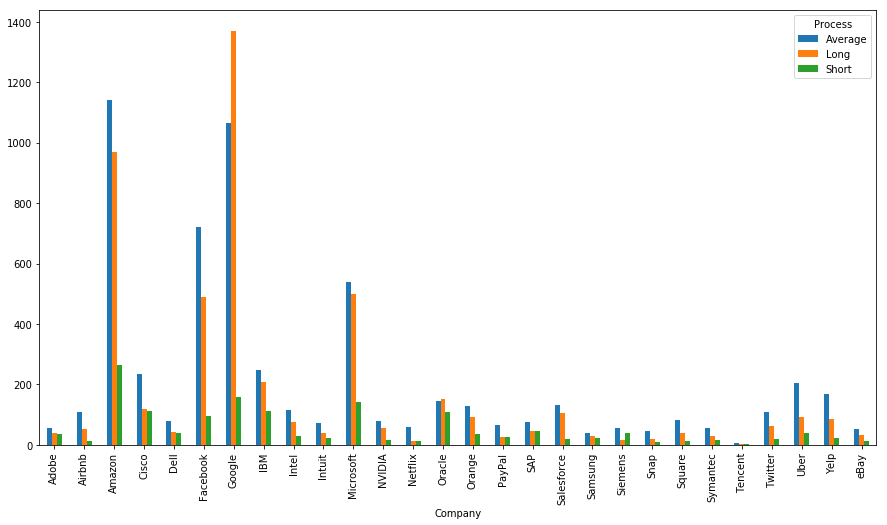

In [126]:
# Group the DataFrame by "Company" and "Process", count the number of elements,
# then unstack by "Process", then plot a bar chart
df.groupby(["Company", "Process"]).size().unstack(level=1).plot(kind="bar", figsize=(15, 8))

## 6. Common pitfals
### 6.1 NaNs
NaNs are stored as floats in pandas, so when an operation fails because of NaNs, it doesn't say that there's a NaN but because that operation doesn't exist for floats.

### 6.2 Changes not Inplace
Most pandas operations aren't inplace by default, so if you make changes to your DataFrame, you need to assign the changes back to your DataFrame. You can make changes inplace by setting argument inplace=True.

In [131]:
# "Process" column is still in df
df.drop(columns=["Process"])
df.columns

# To make changes to df, set `inplace=True`
df.drop(columns=["Process"], inplace=True)
# This is equivalent to
# df = df.drop(columns=["Process"])
df.columns

Index(['Company', 'Title', 'Job', 'Level', 'Date', 'Upvotes', 'Offer',
       'Experience', 'Difficulty', 'Review'],
      dtype='object')